# Appendix 1: Add noise and estimate HMP on the accumulation simulation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from warnings import warn
import hmp
from mne.io import read_info
from scipy.signal import windows
from mne.viz import plot_topomap
from mne.stats import permutation_cluster_1samp_test


# Simulation specific libraries
import pandas as pd

# Reading data as in other notebooks
eeg_data_path = os.path.join('data','preprocessed/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(eeg_data_path) if '.fif' in x]#Extracting subject name based on the file name
subj_files = [eeg_data_path+x+'.fif' for x in subj_names]#Create a list of files that can be read from the folder

# Load sensor position for an example participants (assumes all have the same channel position)
info = read_info(subj_files[0], verbose=True)

sfreq = 100# Downsampling to increase speed and reduce RAM usage for simulations
tstep = (1000/sfreq) #Time step for plotting

epoch_data = hmp.io.read_mne_data(subj_files, epoched=True, 
                                     sfreq=sfreq, 
                                     lower_limit_rt=.1,
                                     offset_after_resp=.01,#add 10ms, avoid edge effects
                                     reject_threshold=1e-4,
                                     verbose=False,
                                     subj_idx=subj_names)

Processing participant data/preprocessed/6_epo.fif's epoched eeg
0 trials rejected based on threshold of 0.0001
1093 trials were retained for participant data/preprocessed/6_epo.fif
Processing participant data/preprocessed/19_epo.fif's epoched eeg
2 trials rejected based on threshold of 0.0001
1108 trials were retained for participant data/preprocessed/19_epo.fif
Processing participant data/preprocessed/20_epo.fif's epoched eeg
17 trials rejected based on threshold of 0.0001
1098 trials were retained for participant data/preprocessed/20_epo.fif
Processing participant data/preprocessed/10_epo.fif's epoched eeg
1 trials rejected based on threshold of 0.0001
1102 trials were retained for participant data/preprocessed/10_epo.fif
Processing participant data/preprocessed/0_epo.fif's epoched eeg
8 trials rejected based on threshold of 0.0001
1102 trials were retained for participant data/preprocessed/0_epo.fif
Processing participant data/preprocessed/11_epo.fif's epoched eeg
12 trials rejecte

# Re-estimate HMP

In [2]:
# Transforming data to PC space
hmp_data = hmp.preprocessing.Preprocessing(epoch_data, n_comp=15, apply_zscore='participant', copy=True)
# Perfroming crosscorrealtion of PC space data and template
event_properties = hmp.patterns.HalfSine.create_expected(sfreq=epoch_data.sfreq)
trial_data = hmp.trialdata.TrialData.from_preprocessed_data(preprocessed=hmp_data, pattern=event_properties.template)
# Use a cumulative fit to infer the number of events
model = hmp.models.CumulativeEstimationModel(event_properties)
model.fit(trial_data)
_, estimates = model.fitted_model.transform(trial_data)

  0%|          | 0/74 [00:00<?, ?it/s]

Transition event 1 found around time 100.0
Transition event 2 found around time 300.0
Transition event 3 found around time 680.0

All events found, refitting final combination.
Estimating 3 events model


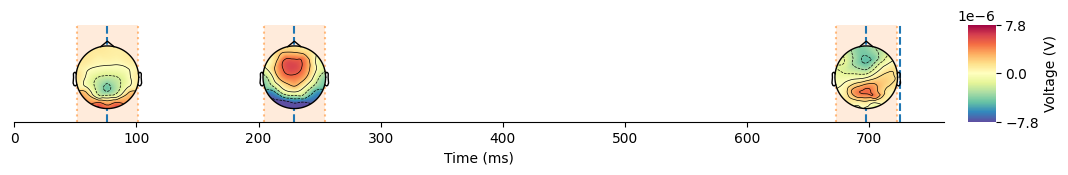

In [3]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, as_time=True, colorbar=True,)

# Performing simulations

In [4]:
# Read simulation funtions from module
from accumulation_simulation import HalfSine, EvidenceAccumulation, simulate_from_hmpfit

# Recovering times and activation amplitudes from the real data
by_trial_weights = hmp.utils.event_channels(epoch_data, estimates, mean=False).squeeze()
times = hmp.utils.event_times(estimates, add_rt=True)

#  Defining and simulating from the assumptions for a model with the first two visual ERPs as half-sine and the last event as an evidence accumulation process
accumulation_assumption = {0:HalfSine(sfreq), 1:HalfSine(sfreq), 2:EvidenceAccumulation(sfreq, drift_rate=.01)}
accumulation_sim_with_noise = simulate_from_hmpfit(epoch_data, by_trial_weights, times, accumulation_assumption, add_noise=True)

In [5]:
# Transforming data to PC space
hmp_data_sim = hmp.preprocessing.Preprocessing(accumulation_sim_with_noise, n_comp=15, apply_zscore='participant', copy=True)
# Perfroming crosscorrealtion of PC space data and template
trial_data_sim = hmp.trialdata.TrialData.from_preprocessed_data(preprocessed=hmp_data_sim, pattern=event_properties.template)
# Use a cumulative fit to infer the number of events
model_accumulation = hmp.models.CumulativeEstimationModel(event_properties)
model_accumulation.fit(trial_data_sim)

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/preprocessing.py:361: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


  0%|          | 0/74 [00:00<?, ?it/s]

Transition event 1 found around time 130.0
Transition event 2 found around time 310.0
Transition event 3 found around time 650.0

All events found, refitting final combination.
Estimating 3 events model


In [6]:
# Use fitted model parameters to transform the data in event probability space
_, estimates_accumulation = model_accumulation.fitted_model.transform(trial_data)

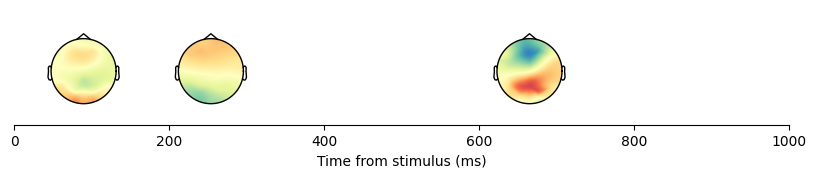

In [7]:
fig, ax = plt.subplots(1,figsize=(10,1.5), sharex=True)

_ = hmp.visu.plot_topo_timecourse(accumulation_sim_with_noise, estimates_accumulation, info, as_time=True, ax=ax, event_lines=None, 
                 vmin=-5e-6, vmax=5e-6, colorbar=False, max_time=1000, contours=False, magnify=1.25,
                 times_to_display=np.array([1100]))

ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left']].set_visible(False)

ax.set_xlim(0, 1000)
ax.set_xlabel(r'Time from stimulus (ms)')
# plt.tight_layout()
fig.savefig('plots/HMP_solution_HMP-on-CPP.png', dpi=300, transparent=True, bbox_inches='tight')

In [8]:
times_sp = hmp.utils.event_times(estimates_accumulation, mean=False, add_rt=True, add_stim=True)

tstep = 1000/sfreq 

data = accumulation_sim_with_noise.stack({'trial':['participant','epoch']}).data.dropna('trial', how="all")
data['stimulus'] = data.stimulus.astype(int)
data['rt'] = times_sp[:,-1]*tstep
data['Stimulus'] = times_sp[:,0]*tstep
data['P100'] = times_sp[:,1]*tstep
data['N200'] = times_sp[:,2]*tstep
data['CPP'] = times_sp[:,3]*tstep
weights =  hmp.utils.event_channels(accumulation_sim_with_noise, estimates_accumulation, mean=True)

name_sat = {'speed':'Speed','accuracy':'Accuracy'}
ax_sat = {"speed":0, "accuracy":1}
channels = info['ch_names'][:32]
decision_event = 2

In [9]:
contrasts = (np.linspace(0.034999999,0.9550001,11)*100)
color_cont_greys = {x: plt.cm.Greys(x/100) for x in contrasts}
color_cont_spd = {x: plt.cm.Reds(x/100) for x in contrasts}
color_cont_acc = {x: plt.cm.Blues(x/100) for x in contrasts}
color_sat = {'speed':color_cont_spd,'accuracy':color_cont_acc}

contrasts_bin = (np.linspace(0.034999999,0.9550001,3)*100)
color_cont_grey_bin = {x: plt.cm.Greys(x/100) for x in contrasts_bin}
color_cont_spd_bin = {x: plt.cm.Reds(x/100) for x in contrasts_bin}
color_cont_acc_bin = {x: plt.cm.Blues(x/100) for x in contrasts_bin}
color_sat_bin = {'speed':color_cont_spd_bin,'accuracy':color_cont_acc_bin}

Using a threshold of 2.059539
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 2 clusters


/tmp/ipykernel_1095860/212288281.py:58: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  test_stats = permutation_cluster_1samp_test(diff)


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Using a threshold of 2.059539
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 1 cluster


/tmp/ipykernel_1095860/212288281.py:58: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  test_stats = permutation_cluster_1samp_test(diff)


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

/tmp/ipykernel_1095860/212288281.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


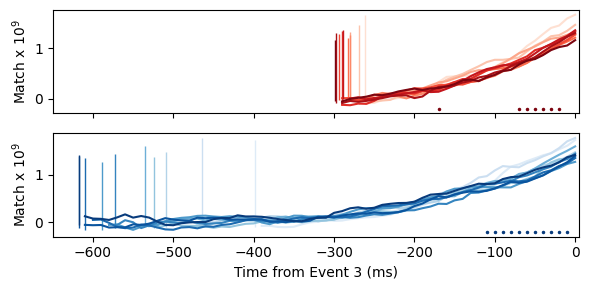

In [10]:
fig5 = plt.figure(constrained_layout=True, figsize=(6,3))

widths = [30]
heights = [1, 1]
spec5 = fig5.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)

baseline = np.array([ -.65])*sfreq
n_samples = np.array([.005])*sfreq
sig_ylim = [-.2]

intervals = [['N200','CPP']]

for event in [2]:

    for c, SAT in enumerate(["speed","accuracy"]):
        ax = fig5.add_subplot(spec5[c, 0])
        for j, cont in enumerate(list(zip(contrasts, np.roll(contrasts, -1)))[:-1]):
            data_left_sp = data.where((data.stimulus > cont[0]) & (data.stimulus <= cont[1])& (data.condition == SAT), drop=True)
            if SAT == 'accuracy':
                ax.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True)
                ax.set_xlabel(f'Time from Event {event+1} (ms)')
            else:
                ax.tick_params(bottom=True, labelbottom=False, left=True, labelleft=True)
                # ax.set_title(f'{intervals[0][0]} to {intervals[0][1]}')
            centered = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
                event=event+1, n_samples=n_samples[0], baseline=baseline[0])
            mean_time = (data_left_sp[intervals[0][0]].mean()-data_left_sp[intervals[0][1]].mean())/tstep
            centered = centered.sel(sample=slice(mean_time, n_samples[0]))

            timecourse = centered.data.unstack().mean(['epoch']).mean('participant').data.T@weights.sel(event=event).values
            timecourse *= 1e10
            ax.plot(centered.sample*tstep, timecourse,
                                 color=color_sat[SAT][cont[1]])
            ax.vlines(mean_time*tstep, 
                      np.nanmin(timecourse), np.nanmax(timecourse), 
                      color=color_sat[SAT][cont[1]], alpha=1, lw=1)

            ax.set_xlim(baseline[0]*tstep, n_samples[0]*tstep)
            ax.set_ylabel(r'Match x $10^{9}$')
        
        #Statistical testing on binarized contrast values
        activ = np.zeros((2, len(epoch_data.participant), int((abs(baseline[0])+n_samples[0]))))*np.nan
        for j, cont in enumerate(list(zip(contrasts_bin, np.roll(contrasts_bin, -1)))[:-1]):
            data_left_sp = data.where((data.stimulus > cont[0]) & (data.stimulus <= cont[1])& (data.condition == SAT), drop=True).dropna('trial', how="all")
            centered = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
                event=event+1, n_samples=n_samples[0], baseline=baseline[0])
            sample_range = centered.sample.values
            centered = centered.data.unstack()
            mean_time = int(np.rint((data_left_sp[intervals[0][0]].mean()-data_left_sp[intervals[0][1]].mean())/tstep))
            centered = centered.sel(sample=slice(mean_time, n_samples[0]))
            participant_erp = np.zeros((len(centered.participant), len(centered.sample)))*np.nan
            for i, participant in enumerate(centered.participant):
                participant_erp[i] = centered.sel(participant = participant).mean(['epoch']).data.T@weights.sel(event=event).values[:,0]
            activ[j, :, -len(centered.sample):] = participant_erp
        diff = activ[0] - activ[1]
        diff = diff[np.isfinite(diff[:,-1]),:]
        test_stats = permutation_cluster_1samp_test(diff)
        if isinstance(test_stats[1], list):
            sig = np.concatenate([arr[0] for arr in test_stats[1]])
        else: sig =  test_stats[1]
        if len(sig ) > 0:
            ax.plot((sample_range*tstep)[sig], np.repeat(sig_ylim[0], len(sig)), '.', color=color_sat_bin[SAT][cont[1]], markersize=3)
            
plt.tight_layout()
plt.savefig('plots/ERPs_partition_simulated.png',dpi=300,transparent=True,bbox_inches='tight')